In [1]:
!pip install kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"mcparadip","key":"ee60bb4deb5f1780508fbc0a864ea7dd"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

!mkdir -p /content/input
!cd /content/input
!kaggle datasets download --path /content/input --unzip soumikrakshit/anime-faces
!cd /content

 95% 417M/441M [00:06<00:00, 49.7MB/s]
100% 441M/441M [00:06<00:00, 67.7MB/s]


In [2]:
%tensorflow_version 2.x
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Activation, Dense, Conv2D, MaxPooling2D, Flatten, Reshape, UpSampling2D
from google.colab import drive
from imageio import imread
from glob import iglob
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import h5py
import os

drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
# tf.config.experimental_connect_to_cluster(resolver)
# # This is the TPU initialization code that has to be at the beginning.
# tf.tpu.experimental.initialize_tpu_system(resolver)
# strategy = tf.distribute.experimental.TPUStrategy(resolver)

In [0]:
def build_encoder():
    inputs = Input(shape=(64, 64, 3), name="enc_input")

    outputs = Conv2D(120, (3, 3), activation="relu", padding="same")(inputs)
    outputs = MaxPooling2D((2, 2), padding="same")(outputs)

    outputs = Conv2D(160, (3, 3), activation="relu", padding="same")(outputs)
    outputs = MaxPooling2D((2, 2), padding="same")(outputs)

    outputs = Conv2D(200, (3, 3), activation="relu", padding="same")(outputs)
    outputs = MaxPooling2D((2, 2), padding="same")(outputs)

    outputs = Conv2D(240, (3, 3), activation="relu", padding="same")(outputs)
    outputs = MaxPooling2D((2, 2), padding="same")(outputs)

    outputs = Flatten()(outputs)

    outputs = Dense(300, activation="relu")(outputs)

    return Model(inputs, outputs)

In [0]:
def build_decoder():
    inputs = Input(shape=(300,), name="dec_input")

    outputs = Dense(4 * 4 * 240)(inputs)
    outputs = Reshape((4, 4, 240))(outputs)

    outputs = UpSampling2D()(outputs)
    outputs = Conv2D(200, (3, 3), activation="relu", padding="same")(outputs)

    outputs = UpSampling2D()(outputs)
    outputs = Conv2D(160, (3, 3), activation="relu", padding="same")(outputs)

    outputs = UpSampling2D()(outputs)
    outputs = Conv2D(120, (3, 3), activation="relu", padding="same")(outputs)

    outputs = UpSampling2D()(outputs)
    outputs = Conv2D(15, (3, 3), activation="relu", padding="same")(outputs)

    outputs = Conv2D(3, (3, 3), padding="same")(outputs)
    outputs = Activation("sigmoid")(outputs)

    return Model(inputs, outputs)

In [5]:
# with strategy.scope():
encoder = build_encoder()
decoder = build_decoder()

inputs = Input(shape=(64, 64, 3), name="input")
outputs = decoder(encoder(inputs))

model = Model(inputs, outputs)
model.summary()

model.load_weights("/content/drive/My Drive/waifu editor/checkpoints/cp.h5")

model.compile(optimizer="adam", loss="mse")

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 64, 64, 3)]       0         
_________________________________________________________________
model (Model)                (None, 300)               2049060   
_________________________________________________________________
model_1 (Model)              (None, 64, 64, 3)         2065743   
Total params: 4,114,803
Trainable params: 4,114,803
Non-trainable params: 0
_________________________________________________________________


In [0]:
faces = list(iglob("/content/input/data/*.png"))
faces = [imread(p) / 255 for p in faces]
faces = np.stack(faces)

dataset = tf.data.Dataset.from_tensor_slices((faces, faces)).shuffle(3000).batch(64)

In [0]:
cpcb = tf.keras.callbacks.ModelCheckpoint(filepath="/content/drive/My Drive/waifu editor/checkpoints/cp.h5", save_weights_only=True, monitor="loss", mode="min", save_best_only=True)
model.fit(dataset, initial_epoch=500, epochs=10000, callbacks=[cpcb])

Epoch 501/10000
337/337 [==============================] - 49s 147ms/step - loss: 0.0129
Epoch 502/10000
337/337 [==============================] - 48s 144ms/step - loss: 0.0114
Epoch 503/10000
337/337 [==============================] - 48s 142ms/step - loss: 0.0115
Epoch 504/10000
337/337 [==============================] - 48s 142ms/step - loss: 0.0116
Epoch 505/10000
337/337 [==============================] - 48s 142ms/step - loss: 0.0115
Epoch 506/10000
337/337 [==============================] - 48s 142ms/step - loss: 0.0116
Epoch 507/10000
337/337 [==============================] - 48s 142ms/step - loss: 0.0116
Epoch 508/10000
337/337 [==============================] - 48s 142ms/step - loss: 0.0115
Epoch 509/10000
337/337 [==============================] - 48s 142ms/step - loss: 0.0116
Epoch 510/10000
337/337 [==============================] - 48s 142ms/step - loss: 0.0116
Epoch 511/10000
337/337 [==============================] - 48s 142ms/step - loss: 0.0116
Epoch 512/10000
337/3

In [0]:
rec = model.predict(faces[:100])

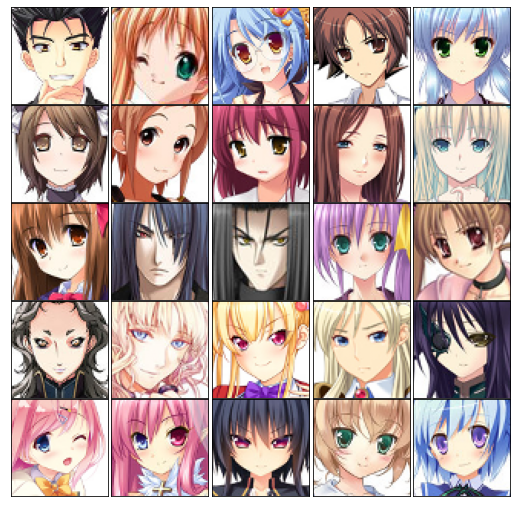

In [8]:
fig, axes = plt.subplots(5, 5, figsize=(9, 9),
                         subplot_kw={"xticks": [], "yticks": []},
                         gridspec_kw=dict(hspace=0.01, wspace=0.01))
for i, ax in enumerate(axes.flat):
    ax.imshow(faces[i].reshape(64, 64, 3))

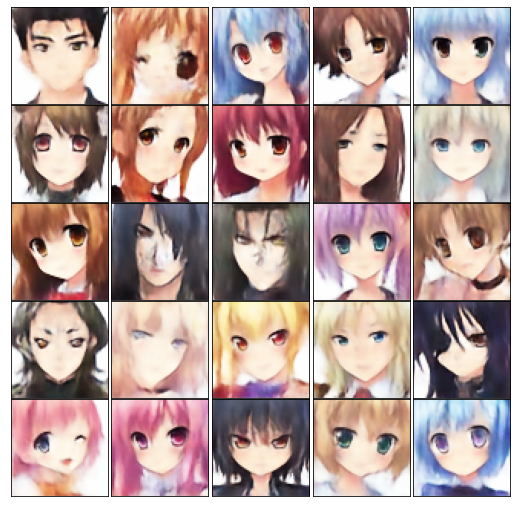

In [9]:
fig, axes = plt.subplots(5, 5, figsize=(9, 9),
                         subplot_kw={"xticks": [], "yticks": []},
                         gridspec_kw=dict(hspace=0.01, wspace=0.01))
for i, ax in enumerate(axes.flat):
    ax.imshow(rec[i].reshape(64, 64, 3))

In [0]:
encoder.save("/content/drive/My Drive/waifu editor/encoder.h5")
decoder.save("/content/drive/My Drive/waifu editor/decoder.h5")
model.save("/content/drive/My Drive/waifu editor/model.h5")